# Chapter 7 - Backpropagation Versus Perturbation Explainability

**Saliency Maps** are backpropagation-based XAI technique that extracts Region of Interest (ROI) and highlights feature importance to human visual perception. This sample notebook is tested with TensorFlow 2.11.0 and Python 3.9.10 using Amazon SageMaker Studio ml.m5.large general-purpose instance with 2 vCPU and 8 GiB. Here is the [link](https://aws.amazon.com/sagemaker/pricing/) regarding instance pricing reference. Alternatively, you can try this on your preferred IDE.

## Install and Load Libraries

In [2]:
# Install essential libraries

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from platform import python_version
import os
import warnings

warnings.filterwarnings("ignore")

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

# Validate dependencies
print(f'TensorFlow version: {tf.__version__}')
print(f'Python version: {python_version()}')

%matplotlib inline

TensorFlow version: 2.11.0
Python version: 3.9.10


## Load a Pre-trained Model

We will load a VGG16 image classification model with pre-trained weights on ImageNet and view a summary of the model architecture.

In [3]:
model = tf.keras.applications.VGG16(weights='imagenet')
model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

## Load and Predict an Image

Load a sample input shape, set the target input size, and obtain predicted classes.

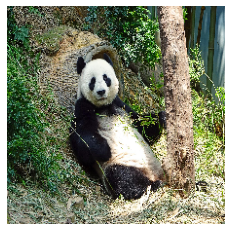

In [4]:
# Load a sample image and set target input size

img_path = 'panda.jpeg'

image = tf.keras.utils.load_img(img_path, target_size=(224,224))

plt.imshow(image)
plt.axis('off')
plt.show()

In [5]:
# Preprocess image and obtain a prediction

img = tf.keras.utils.img_to_array(image)
img = img.reshape((1, *img.shape))
y_pred = model.predict(img)

# Top 5 predicted classes
top5 = tf.keras.applications.vgg16.decode_predictions(y_pred, top=5)
print('Top 5 classes:')
top5

1/1 [==============================] - 1s 549ms/step
Top 5 classes:


[[('n02510455', 'giant_panda', 0.95593),
  ('n02509815', 'lesser_panda', 0.039848916),
  ('n02483362', 'gibbon', 0.0019217731),
  ('n02443114', 'polecat', 0.0008564722),
  ('n02488702', 'colobus', 0.000399229)]]

## Calculate Gradients

TensorFlow provides tf.GradientTape API for automatic differentiation or autodiff to evaluate gradients with respect to the context within tf.GradientTape via backpropagation. Let's compute the gradients for the top class.

In [6]:
# Compute gradients contributing to the top class

images = tf.Variable(img, dtype=float)

with tf.GradientTape() as tape:
    pred = model(images, training=False)
    sorted_class = np.argsort(pred.numpy().flatten())[::-1]
    loss = pred[0][sorted_class[0]]

grads = tape.gradient(loss, images)

In [7]:
# Find the max of absolute values of gradients to determine saliency map

grads_abs = tf.math.abs(grads)
grads_max = np.max(grads_abs, axis=3)[0]

In [8]:
# Normalize the gradients

gmin, gmax  = np.min(grads_max), np.max(grads_max)
grads_eval = (grads_max - gmin) / (gmax - gmin + 1e-18)

## Visualize Saliency Maps

We can see the panda's eyes and nose contribute to the feature importance score to its predicted class as a giant panda.

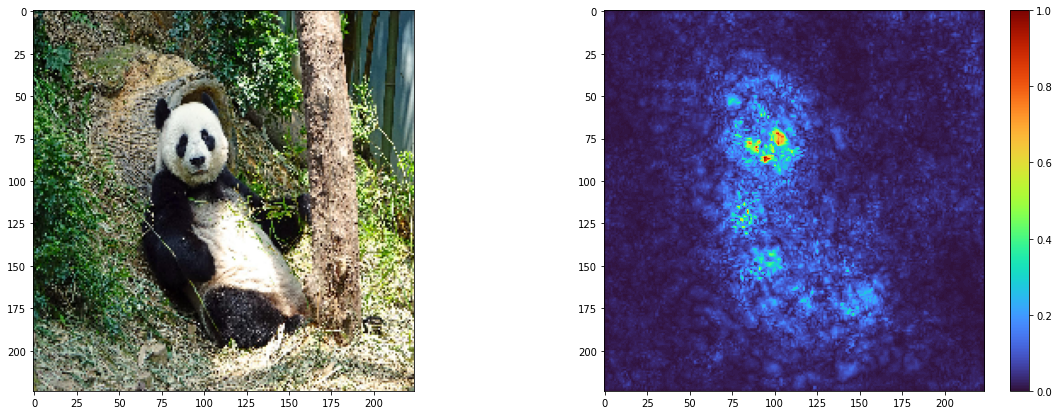

In [9]:
# Create and visualize salience maps

fig, axes = plt.subplots(1,2,figsize=(20,7))
axes[0].imshow(image)
fig.colorbar(axes[1].imshow(grads_eval,cmap="turbo"))
plt.savefig('panda_saliency_maps.png', bbox_inches='tight')

This concludes our walkthrough of saliency maps. You can try to replace the sample image and swap out the [pre-trained models](https://www.tensorflow.org/api_docs/python/tf/keras/applications).